<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W1/tutorials/W1D2_ModelingPractice/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 1, Day 2, Tutorial 1
# Modeling Practice: Framing the question

__Content creators:__ Marius 't Hart, Paul Schrater, Gunnar Blohm

__Content reviewers:__ Norma Kuhn, Saeed Salehi, Madineh Sarvestani, Spiros Chavlis, Michael Waskom

---
# Tutorial objectives
Yesterday you gained some understanding of what models can buy us in neuroscience. But how do you build a model? Today, we will try to clarify the process of computational modeling, by building a simple model.

We will investigate a simple phenomenon, working through the 10 steps of modeling ([Blohm et al., 2019](https://doi.org/10.1523/ENEURO.0352-19.2019)) in two notebooks: 

**Framing the question**

1. finding a phenomenon and a question to ask about it
2. understanding the state of the art
3. determining the basic ingredients
4. formulating specific, mathematically defined hypotheses

**Implementing the model**

5. selecting the toolkit
6. planning the model
7. implementing the model

**Model testing**

8. completing the model
9. testing and evaluating the model

**Publishing**

10. publishing models

Tutorial 1 (this notebook) will cover the steps 1-5, while Tutorial 2 will cover the steps 6-10.

**TD**: All activities you should perform are labeled with **TD#.#**, which stands for "To Do", micro-tutorial number, activity number. They can be found in the Table of Content on the left side of the notebook. Make sure you complete all within a section before moving on!

**Run**: Some code chunks' names start with "Run to ... (do something)". These chunks are purely to produce a graph or calculate a number. You do not need to look at or understand the code in those chunks.

# Setup


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from IPython.display import YouTubeVideo

In [21]:
# @title Figure settings
import ipywidgets as widgets

%config InlineBackend.figure_format = 'retina'

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [22]:
# @title Helper functions


def my_moving_window(x, window=3, FUN=np.mean):
  """
  Calculates a moving estimate for a signal

  Args:
      x (numpy.ndarray): a vector array of size N
      window (int): size of the window, must be a positive integer
      FUN (function): the function to apply to the samples in the window

  Returns:
      (numpy.ndarray): a vector array of size N, containing the moving
      average of x, calculated with a window of size window

  There are smarter and faster solutions (e.g. using convolution) but this
  function shows what the output really means. This function skips NaNs, and
  should not be susceptible to edge effects: it will simply use
  all the  available samples, which means that close to the edges of the
  signal or close to NaNs, the output will just be based on fewer samples. By
  default, this function will apply a mean to the samples in the window, but
  this can be changed to be a max/min/median or other function that returns a
  single numeric value based on a sequence of values.
  """

  # if data is a matrix, apply filter to each row:
  if len(x.shape) == 2:
    output = np.zeros(x.shape)
    for rown in range(x.shape[0]):
      output[rown, :] = my_moving_window(x[rown, :],
                                         window=window,
                                         FUN=FUN)
    return output

  # make output array of the same size as x:
  output = np.zeros(x.size)

  # loop through the signal in x
  for samp_i in range(x.size):

    values = []

    # loop through the window:
    for wind_i in range(int(1 - window), 1):

      if ((samp_i + wind_i) < 0) or (samp_i + wind_i) > (x.size - 1):
        # out of range
        continue

      # sample is in range and not nan, use it:
      if not(np.isnan(x[samp_i + wind_i])):
        values += [x[samp_i + wind_i]]

    # calculate the mean in the window for this point in the output:
    output[samp_i] = FUN(values)

  return output


def my_plot_percepts(datasets=None, plotconditions=False):

  if isinstance(datasets, dict):
    # try to plot the datasets
    # they should be named...
    # 'expectations', 'judgments', 'predictions'

    plt.figure(figsize=(8, 8))  # set aspect ratio = 1? not really

    plt.ylabel('perceived self motion [m/s]')
    plt.xlabel('perceived world motion [m/s]')
    plt.title('perceived velocities')

    # loop through the entries in datasets
    # plot them in the appropriate way
    for k in datasets.keys():
      if k == 'expectations':

        expect = datasets[k]
        plt.scatter(expect['world'], expect['self'], marker='*',
                    color='xkcd:green', label='my expectations')

      elif k == 'judgments':

        judgments = datasets[k]

        for condition in np.unique(judgments[:, 0]):
          c_idx = np.where(judgments[:, 0] == condition)[0]
          cond_self_motion = judgments[c_idx[0], 1]
          cond_world_motion = judgments[c_idx[0], 2]
          if cond_world_motion == -1 and cond_self_motion == 0:
            c_label = 'world-motion condition judgments'
          elif cond_world_motion == 0 and cond_self_motion == 1:
            c_label = 'self-motion condition judgments'
          else:
            c_label = f"condition {condition:d} judgments"

          plt.scatter(judgments[c_idx, 3], judgments[c_idx, 4],
                      label=c_label, alpha=0.2)

      elif k == 'predictions':

        predictions = datasets[k]

        for condition in np.unique(predictions[:, 0]):
          c_idx = np.where(predictions[:, 0] == condition)[0]
          cond_self_motion = predictions[c_idx[0], 1]
          cond_world_motion = predictions[c_idx[0], 2]
          if cond_world_motion == -1 and cond_self_motion == 0:
            c_label = 'predicted world-motion condition'
          elif cond_world_motion == 0 and cond_self_motion == 1:
            c_label = 'predicted self-motion condition'
          else:
            c_label = f"condition {condition:d} prediction"

          plt.scatter(predictions[c_idx, 4], predictions[c_idx, 3],
                      marker='x', label=c_label)

      else:
        print("datasets keys should be 'hypothesis',\
        'judgments' and 'predictions'")

    if plotconditions:
      # this code is simplified but only works for the dataset we have:
      plt.scatter([1], [0], marker='<', facecolor='none',
                  edgecolor='xkcd:black', linewidths=2,
                  label='world-motion stimulus', s=80)
      plt.scatter([0], [1], marker='>', facecolor='none',
                  edgecolor='xkcd:black', linewidths=2,
                  label='self-motion stimulus', s=80)

    plt.legend(facecolor='xkcd:white')
    plt.show()

  else:
    if datasets is not None:
      print('datasets argument should be a dict')
      raise TypeError


def my_plot_stimuli(t, a, v):
  plt.figure(figsize=(10, 6))
  plt.plot(t, a, label='acceleration [$m/s^2$]')
  plt.plot(t, v, label='velocity [$m/s$]')
  plt.xlabel('time [s]')
  plt.ylabel('[motion]')
  plt.legend(facecolor='xkcd:white')
  plt.show()


def my_plot_motion_signals():
  dt = 1 / 10
  a = gamma.pdf(np.arange(0, 10, dt), 2.5, 0)
  t = np.arange(0, 10, dt)
  v = np.cumsum(a * dt)

  fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharex='col',
                                 sharey='row', figsize=(14, 6))
  fig.suptitle('Sensory ground truth')

  ax1.set_title('world-motion condition')
  ax1.plot(t, -v, label='visual [$m/s$]')
  ax1.plot(t, np.zeros(a.size), label='vestibular [$m/s^2$]')
  ax1.set_xlabel('time [s]')
  ax1.set_ylabel('motion')
  ax1.legend(facecolor='xkcd:white')

  ax2.set_title('self-motion condition')
  ax2.plot(t, -v, label='visual [$m/s$]')
  ax2.plot(t, a, label='vestibular [$m/s^2$]')
  ax2.set_xlabel('time [s]')
  ax2.set_ylabel('motion')
  ax2.legend(facecolor='xkcd:white')

  plt.show()


def my_plot_sensorysignals(judgments, opticflow, vestibular, returnaxes=False,
                           addaverages=False, integrateVestibular=False,
                           addGroundTruth=False):

  if addGroundTruth:
    dt = 1 / 10
    a = gamma.pdf(np.arange(0, 10, dt), 2.5, 0)
    t = np.arange(0, 10, dt)
    v = a

  wm_idx = np.where(judgments[:, 0] == 0)
  sm_idx = np.where(judgments[:, 0] == 1)

  opticflow = opticflow.transpose()
  wm_opticflow = np.squeeze(opticflow[:, wm_idx])
  sm_opticflow = np.squeeze(opticflow[:, sm_idx])

  if integrateVestibular:
    vestibular = np.cumsum(vestibular * .1, axis=1)
    if addGroundTruth:
      v = np.cumsum(a * dt)

  vestibular = vestibular.transpose()
  wm_vestibular = np.squeeze(vestibular[:, wm_idx])
  sm_vestibular = np.squeeze(vestibular[:, sm_idx])

  X = np.arange(0, 10, .1)

  fig, my_axes = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                              figsize=(15, 10))
  fig.suptitle('Sensory signals')

  my_axes[0][0].plot(X, wm_opticflow, color='xkcd:light red', alpha=0.1)
  my_axes[0][0].plot([0, 10], [0, 0], ':', color='xkcd:black')
  if addGroundTruth:
      my_axes[0][0].plot(t, -v, color='xkcd:red')
  if addaverages:
      my_axes[0][0].plot(X, np.average(wm_opticflow, axis=1),
                         color='xkcd:red', alpha=1)

  my_axes[0][0].set_title('optic-flow in world-motion condition')
  my_axes[0][0].set_ylabel('velocity signal [$m/s$]')

  my_axes[0][1].plot(X, sm_opticflow, color='xkcd:azure', alpha=0.1)
  my_axes[0][1].plot([0, 10], [0, 0], ':', color='xkcd:black')
  if addGroundTruth:
      my_axes[0][1].plot(t, -v, color='xkcd:blue')
  if addaverages:
      my_axes[0][1].plot(X, np.average(sm_opticflow, axis=1),
                         color='xkcd:blue', alpha=1)

  my_axes[0][1].set_title('optic-flow in self-motion condition')

  my_axes[1][0].plot(X, wm_vestibular, color='xkcd:light red', alpha=0.1)
  my_axes[1][0].plot([0, 10], [0, 0], ':', color='xkcd:black')
  if addaverages:
      my_axes[1][0].plot(X, np.average(wm_vestibular, axis=1),
                         color='xkcd: red', alpha=1)

  my_axes[1][0].set_title('vestibular signal in world-motion condition')
  if addGroundTruth:
      my_axes[1][0].plot(t, np.zeros(100), color='xkcd:red')
  my_axes[1][0].set_xlabel('time [s]')
  if integrateVestibular:
      my_axes[1][0].set_ylabel('velocity signal [$m/s$]')
  else:
      my_axes[1][0].set_ylabel('acceleration signal [$m/s^2$]')

  my_axes[1][1].plot(X, sm_vestibular, color='xkcd:azure', alpha=0.1)
  my_axes[1][1].plot([0, 10], [0, 0], ':', color='xkcd:black')
  if addGroundTruth:
      my_axes[1][1].plot(t, v, color='xkcd:blue')
  if addaverages:
      my_axes[1][1].plot(X, np.average(sm_vestibular, axis=1),
                         color='xkcd:blue', alpha=1)

  my_axes[1][1].set_title('vestibular signal in self-motion condition')
  my_axes[1][1].set_xlabel('time [s]')

  if returnaxes:
    return my_axes
  else:
    plt.show()


def my_threshold_solution(selfmotion_vel_est, threshold):
  is_move = (selfmotion_vel_est > threshold)
  return is_move


def my_moving_threshold(selfmotion_vel_est, thresholds):

  pselfmove_nomove = np.empty(thresholds.shape)
  pselfmove_move = np.empty(thresholds.shape)
  prop_correct = np.empty(thresholds.shape)
  pselfmove_nomove[:] = np.NaN
  pselfmove_move[:] = np.NaN
  prop_correct[:] = np.NaN

  for thr_i, threshold in enumerate(thresholds):

    # run my_threshold that the students will write:
    try:
      is_move = my_threshold(selfmotion_vel_est, threshold)
    except Exception:
      is_move = my_threshold_solution(selfmotion_vel_est, threshold)

    # store results:
    pselfmove_nomove[thr_i] = np.mean(is_move[0:100])
    pselfmove_move[thr_i] = np.mean(is_move[100:200])

    # calculate the proportion
    # classified correctly: (1 - pselfmove_nomove) + ()
    # Correct rejections:
    p_CR = (1 - pselfmove_nomove[thr_i])
    # correct detections:
    p_D = pselfmove_move[thr_i]

    # this is corrected for proportion of trials in each condition:
    prop_correct[thr_i] = (p_CR + p_D) / 2

  return [pselfmove_nomove, pselfmove_move, prop_correct]


def my_plot_thresholds(thresholds, world_prop, self_prop, prop_correct):

  plt.figure(figsize=(12, 8))
  plt.title('threshold effects')
  plt.plot([min(thresholds), max(thresholds)], [0, 0], ':',
           color='xkcd:black')
  plt.plot([min(thresholds), max(thresholds)], [0.5, 0.5], ':',
           color='xkcd:black')
  plt.plot([min(thresholds), max(thresholds)], [1, 1], ':',
           color='xkcd:black')
  plt.plot(thresholds, world_prop, label='world motion condition')
  plt.plot(thresholds, self_prop, label='self motion condition')
  plt.plot(thresholds, prop_correct, color='xkcd:purple',
           label='correct classification')
  idx = np.argmax(prop_correct[::-1]) + 1
  plt.plot([thresholds[-idx]]*2, [0, 1], '--', color='xkcd:purple',
           label='best classification')
  plt.text(0.7, 0.8,
           f"threshold:{thresholds[-idx]:0.2f}\
           \ncorrect: {prop_correct[-idx]:0.2f}")

  plt.xlabel('threshold')
  plt.ylabel('proportion classified as self motion')
  plt.legend(facecolor='xkcd:white')
  plt.show()


def my_plot_predictions_data(judgments, predictions):

  # conditions = np.concatenate((np.abs(judgments[:, 1]),
  #                             np.abs(judgments[:, 2])))
  # veljudgmnt = np.concatenate((judgments[:, 3], judgments[:, 4]))
  # velpredict = np.concatenate((predictions[:, 3], predictions[:, 4]))

  # self:
  # conditions_self = np.abs(judgments[:, 1])
  veljudgmnt_self = judgments[:, 3]
  velpredict_self = predictions[:, 3]

  # world:
  # conditions_world = np.abs(judgments[:, 2])
  veljudgmnt_world = judgments[:, 4]
  velpredict_world = predictions[:, 4]

  fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharey='row',
                                 figsize=(12, 5))

  ax1.scatter(veljudgmnt_self, velpredict_self, alpha=0.2)
  ax1.plot([0, 1], [0, 1], ':', color='xkcd:black')
  ax1.set_title('self-motion judgments')
  ax1.set_xlabel('observed')
  ax1.set_ylabel('predicted')

  ax2.scatter(veljudgmnt_world, velpredict_world, alpha=0.2)
  ax2.plot([0, 1], [0, 1], ':', color='xkcd:black')
  ax2.set_title('world-motion judgments')
  ax2.set_xlabel('observed')
  ax2.set_ylabel('predicted')

  plt.show()

In [4]:
# @title Data retrieval
import os
fname="W1D2_data.npz"
if not os.path.exists(fname):
  !wget https://osf.io/c5xyf/download -O $fname

filez = np.load(file=fname, allow_pickle=True)
judgments = filez['judgments']
opticflow = filez['opticflow']
vestibular = filez['vestibular']

--2020-08-24 03:37:57--  https://osf.io/c5xyf/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.ca-1.osf.io/v1/resources/hygbm/providers/osfstorage/5ef50e8c02d64d00466cc07d?action=download&direct&version=1 [following]
--2020-08-24 03:37:57--  https://files.ca-1.osf.io/v1/resources/hygbm/providers/osfstorage/5ef50e8c02d64d00466cc07d?action=download&direct&version=1
Resolving files.ca-1.osf.io (files.ca-1.osf.io)... 35.241.38.243
Connecting to files.ca-1.osf.io (files.ca-1.osf.io)|35.241.38.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328774 (321K) [application/octet-stream]
Saving to: ‘W1D2_data.npz’

W1D2_data.npz       100%[===================>] 321.07K   399KB/s    in 0.8s    

2020-08-24 03:38:00 (399 KB/s) - ‘W1D2_data.npz’ saved [328774/328774]



---
# Section 1: Investigating the phenomenon


Video available at https://youtube.com/watch?v=x4b2-hZoyiY


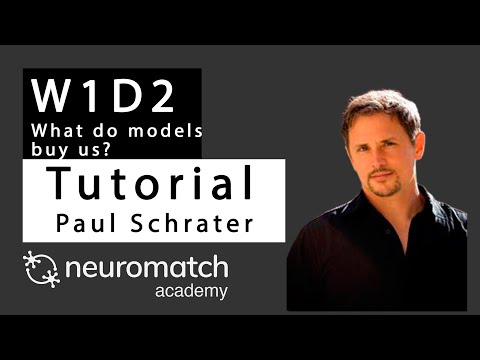

In [5]:
# @title Video 1: Question
video = YouTubeVideo(id='x4b2-hZoyiY', width=854, height=480, fs=1)
print(f"Video available at https://youtube.com/watch?v={video.id}")
video


**Goal**: formulate a good question!

**Background: The train illusion**

In the video you have learnt about the train illusion. In the same situation, we sometimes perceive our own train to be moving and sometimes the other train. How come our perception is ambiguous?

We will build a simple model with the goal _to learn about the process of model building_ (i.e.: not to explain train illusions or get a correct model). To keep this manageable, we use a _simulated_ data set. For the same reason, this tutorial contains both coding and thinking activities. Doing both are essential for success.

Imagine we get data from an experimentalist who collected _judgments_ on self motion and world motion, in two conditions. One where there was only world motion, and one where there was only self motion. In either case, the velocity increased from 0 to 1 m/s across 10 seconds with the same (fairly low) acceleration. Each of these conditions was recorded 100 times:

![illustration of the conditions](https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/NMA-W1D2-fig01.png)

Participants sit very still during the trials and at the end of each 10 s trial they are given two sliders, one to indicate the self-motion velocity (in m/s) and another to indicate the world-motion velocity (in m/s) _at the end of the interval_.

## TD 1.1: Form expectations about the experiment, using the phenomena

In the experiment we get the participants _judgments_ of the velocities they experienced. In the Python chunk below, you should retain the numbers that represent your expectations on the participants' judgments. Remember that in the train illusion people usually experience either self motion or world motion, but not both. 

From the lists, remove those pairs of responses you think are unlikely to be the participants' judgments. The first two pairs of coordinates (1 m/s, 0 m/s, and 0 m/s, 1 m/s) are the stimuli, so those reflect judgments without illusion. Those should stay, but how do you think participants judge velocities when they _do_ experience the illusion?

**Create Expectations**

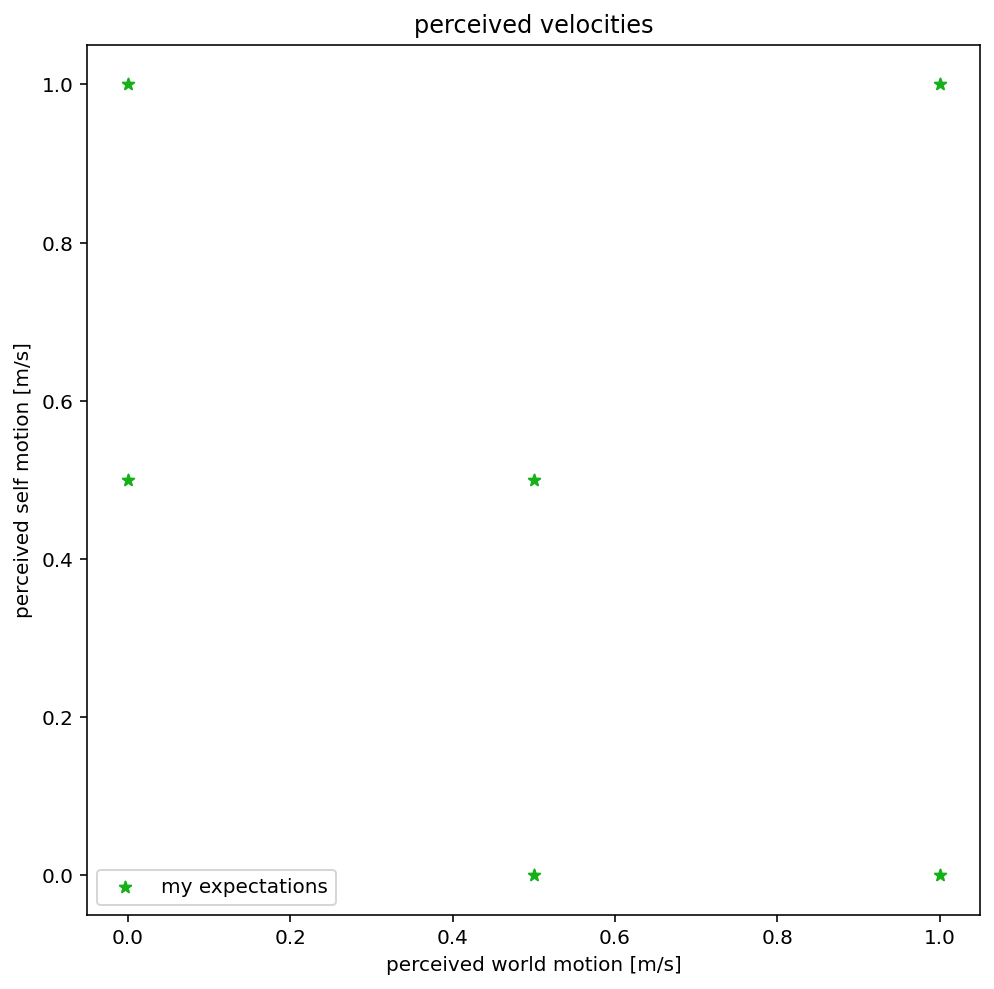

In [6]:
# Create Expectations
###################################################################
# To complete the exercise, remove unlikely responses from the two
# lists. The lists act as X and Y coordinates for a scatter plot,
# so make sure the lists match in length.
###################################################################

world_vel_exp = [1, 0, 1, 0.5, 0.5, 0]
self_vel_exp = [0, 1, 1, 0.5, 0, 0.5]

# The code below creates a figure with your predictions:
my_plot_percepts(datasets={'expectations': {'world': world_vel_exp,
                                            'self': self_vel_exp}})

## **TD 1.2**: Compare Expectations to Data
The behavioral data from our experiment is in a 200 x 5 matrix called `judgments`, where each row indicates a trial.

The first three columns in the `judgments` matrix represent the conditions in the experiment, and the last two columns list the velocity judgments.

![illustration of the judgments matrix](https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/NMA-W1D2-fig02.png)

The condition number can be 0 (world-motion condition, first 100 rows) or 1 (self-motion condition, last 100 rows). Columns 1 and 2 respectively list the true self- and world-motion velocities in the experiment. You will not have to use the first three columns.

The motion judgements (columns 3 and 4) are the participants judgments of the self-motion velocity and world-motion velocity respectively, and should show the illusion. Let's plot the judgment data, along with the true motion of the stimuli in the experiment:


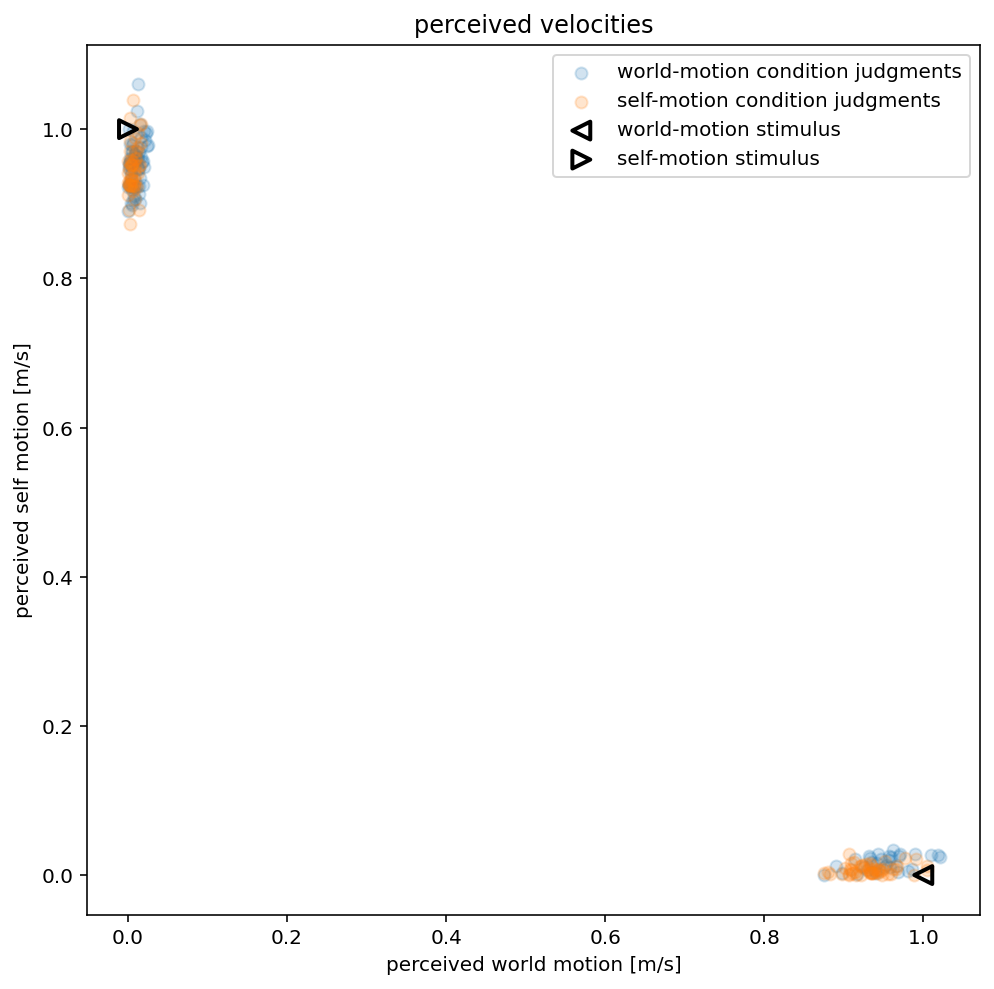

In [7]:
#@title
#@markdown Run to plot perceptual judgments

my_plot_percepts(datasets={'judgments': judgments}, plotconditions=True)

## TD 1.3: Think about what the data is saying, by answering these questions:
* How does it differ from your initial expectations? 
* Where are the clusters of data, roughly?
* What does it mean that the some of the judgments from the world-motion condition are close to the self-motion stimulus and vice versa?
* Why are there no data points in the middle?
* What aspects of the data require explanation?

---
# Section 2: Understanding background 


Video available at https://youtube.com/watch?v=DcJ91h5Ekis


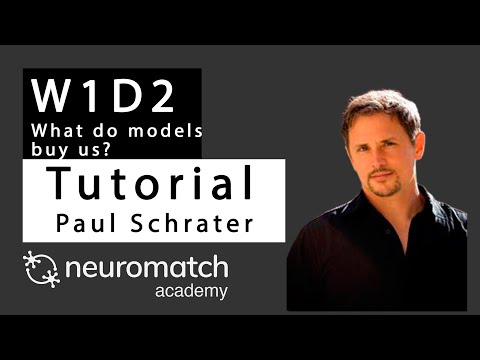

In [8]:
# @title Video 2: Background
video = YouTubeVideo(id='DcJ91h5Ekis', width=854, height=480, fs=1)
print(f"Video available at https://youtube.com/watch?v={video.id}")
video

**Goal:** Now that we have an interesting phenomenon, we gather background information which will refine our questions, and we lay the groundwork for developing scientific hypotheses. 

**Background: Motion Sensing**: 

Our self-motion percepts are based on our visual (optic flow) and vestibular (inner ear) sensing. Optic flow is the moving image on the retina caused by either self or world-motion. Vestibular signals are related to bodily self- movements only. The two signals can be understood as velocity in $m/s$ (optic flow) and acceleration in $m/s^2$ (vestibular signal). We'll first look at the ground truth which is stimulating the senses in our experiment.


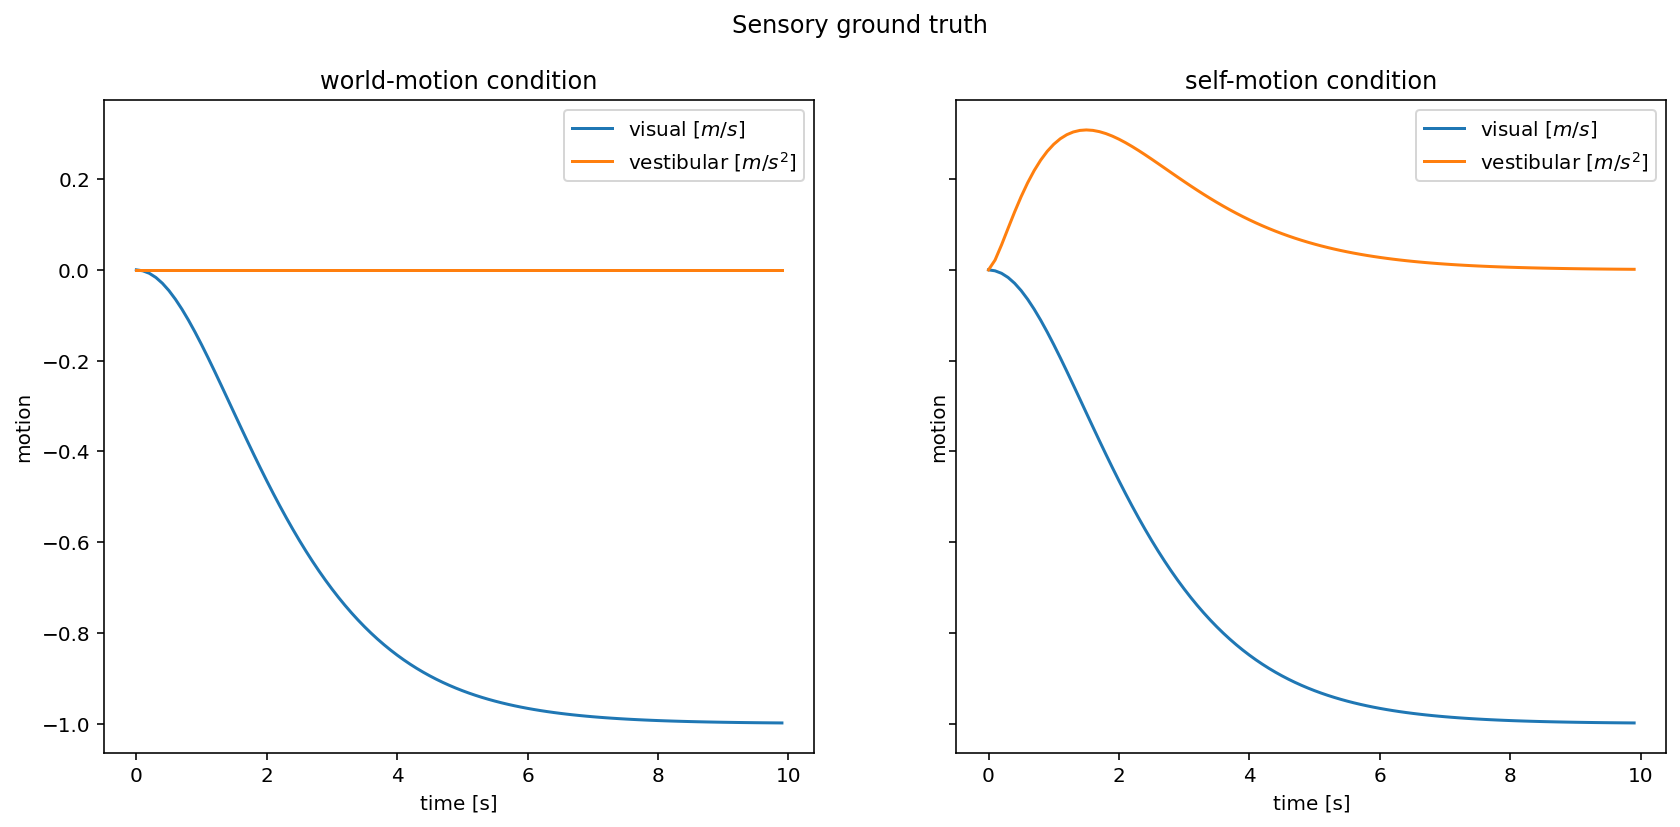

In [9]:
#@markdown **Run to plot motion stimuli**
my_plot_motion_signals()

## TD 2.1: Examine the differences between the conditions:

* how are the visual inputs (optic flow) different between the conditions?
* how are the vestibular signals different between the conditions?
* how might the brain use these signals to determine there is self motion?
* how might the brain use these signals to determine there is world motion?

We can see that, in theory, we have enough information to disambiguate self-motion from world-motion using these signals. Let's go over the logic together. The visual signal is ambiguous, it will be non-zero when there is either self-motion or world-motion. The vestibular signal is specific, it’s only non-zero when there is self-motion. Combining these two signals should allow us to disambiguate the self-motion condition from the world-motion condition!

* In the world-motion condition: The brain can simply compare the visual and vestibular signals. If there is visual motion AND NO vestibular motion, it must be that the world is moving but not the body/self = world-motion judgement.
* In the self-motion condition: We can make a similar comparison. If there is both visual signals AND vestibular signals, it must be that the body/self is moving = self-motion judgement.


**Background: Integrating signals**: 

To understand how the vestibular _acceleration_ signal could underlie the perception of self-motion _velocity_, we assume the brain integrates the signal. This also allows comparing the vestibular signal to the visual signal, by getting them in the same units. Read more about integration on [Wikipedia](https://en.wikipedia.org/wiki/Integral).

Below we will approximate the integral using `np.cumsum()`. The discrete integral would be:

$$v_t = \sum_{k=0}^t a_k\cdot\Delta t  + v_0$$

* $a(t)$ is acceleration as a function of time
* $v(t)$ is velocity as a function of time
* $\Delta t$ is equal to the sample interval of our recorded visual and vestibular signals (0.1 s).
* $v_0$ is the _constant of integration_ which corresponds in the initial velocity at time $0$ (it would have to be known or remembered). Since that is always 0 in our experiment, we will leave it out from here on.

### Numerically Integrating a signal

Below is a chunk of code which uses the `np.cumsum()` function to integrate the acceleration that was used in our (simulated) experiment: `a` over `dt` in order to get a velocity signal `v`.

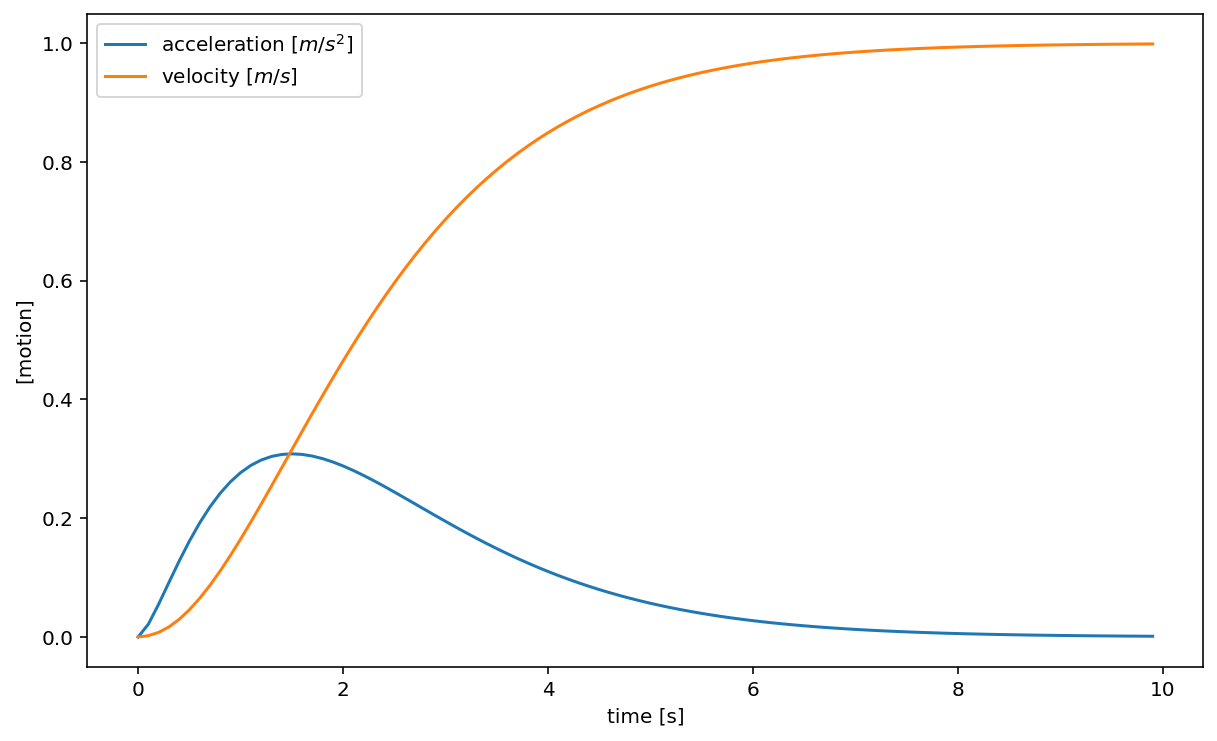

In [10]:
# Check out the code:
dt = 1 / 10
a = gamma.pdf(np.arange(0, 10, dt), 2.5, 0)
t = np.arange(0, 10, dt)

# This does the integration of acceleration into velocity:
v = np.cumsum(a * dt)

my_plot_stimuli(t, a, v)

**Background: Sensory signals are noisy** 

In our experiment, we also recorded sensory signals in the participant. The data come in two 200 x 100 matrices:

`opticflow` (with the visual signals)

and

`vestibular` (with the vestibular signals)

In each of the signal matrices _rows_ (200) represent **trials**, in the same order as in the `judgments` matrix. _Columns_ (100) are **time samples**, representing 10 s collected with a 100 ms time bin. 

![illustration of the signal matrices](https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/NMA-W1D2-fig03.png)

Here we plot the data representing our 'sensory signals':

* plot optic flow signals for self-motion vs world-motion conditions (should be the same)
* plot vestibular signals for self-motion vs world-motion conditions (should be different)

The x-axis is time in seconds, but the y-axis can be one of several, depending on what you do with the signals: $m/s^2$ (acceleration) or $m/s$ (velocity).

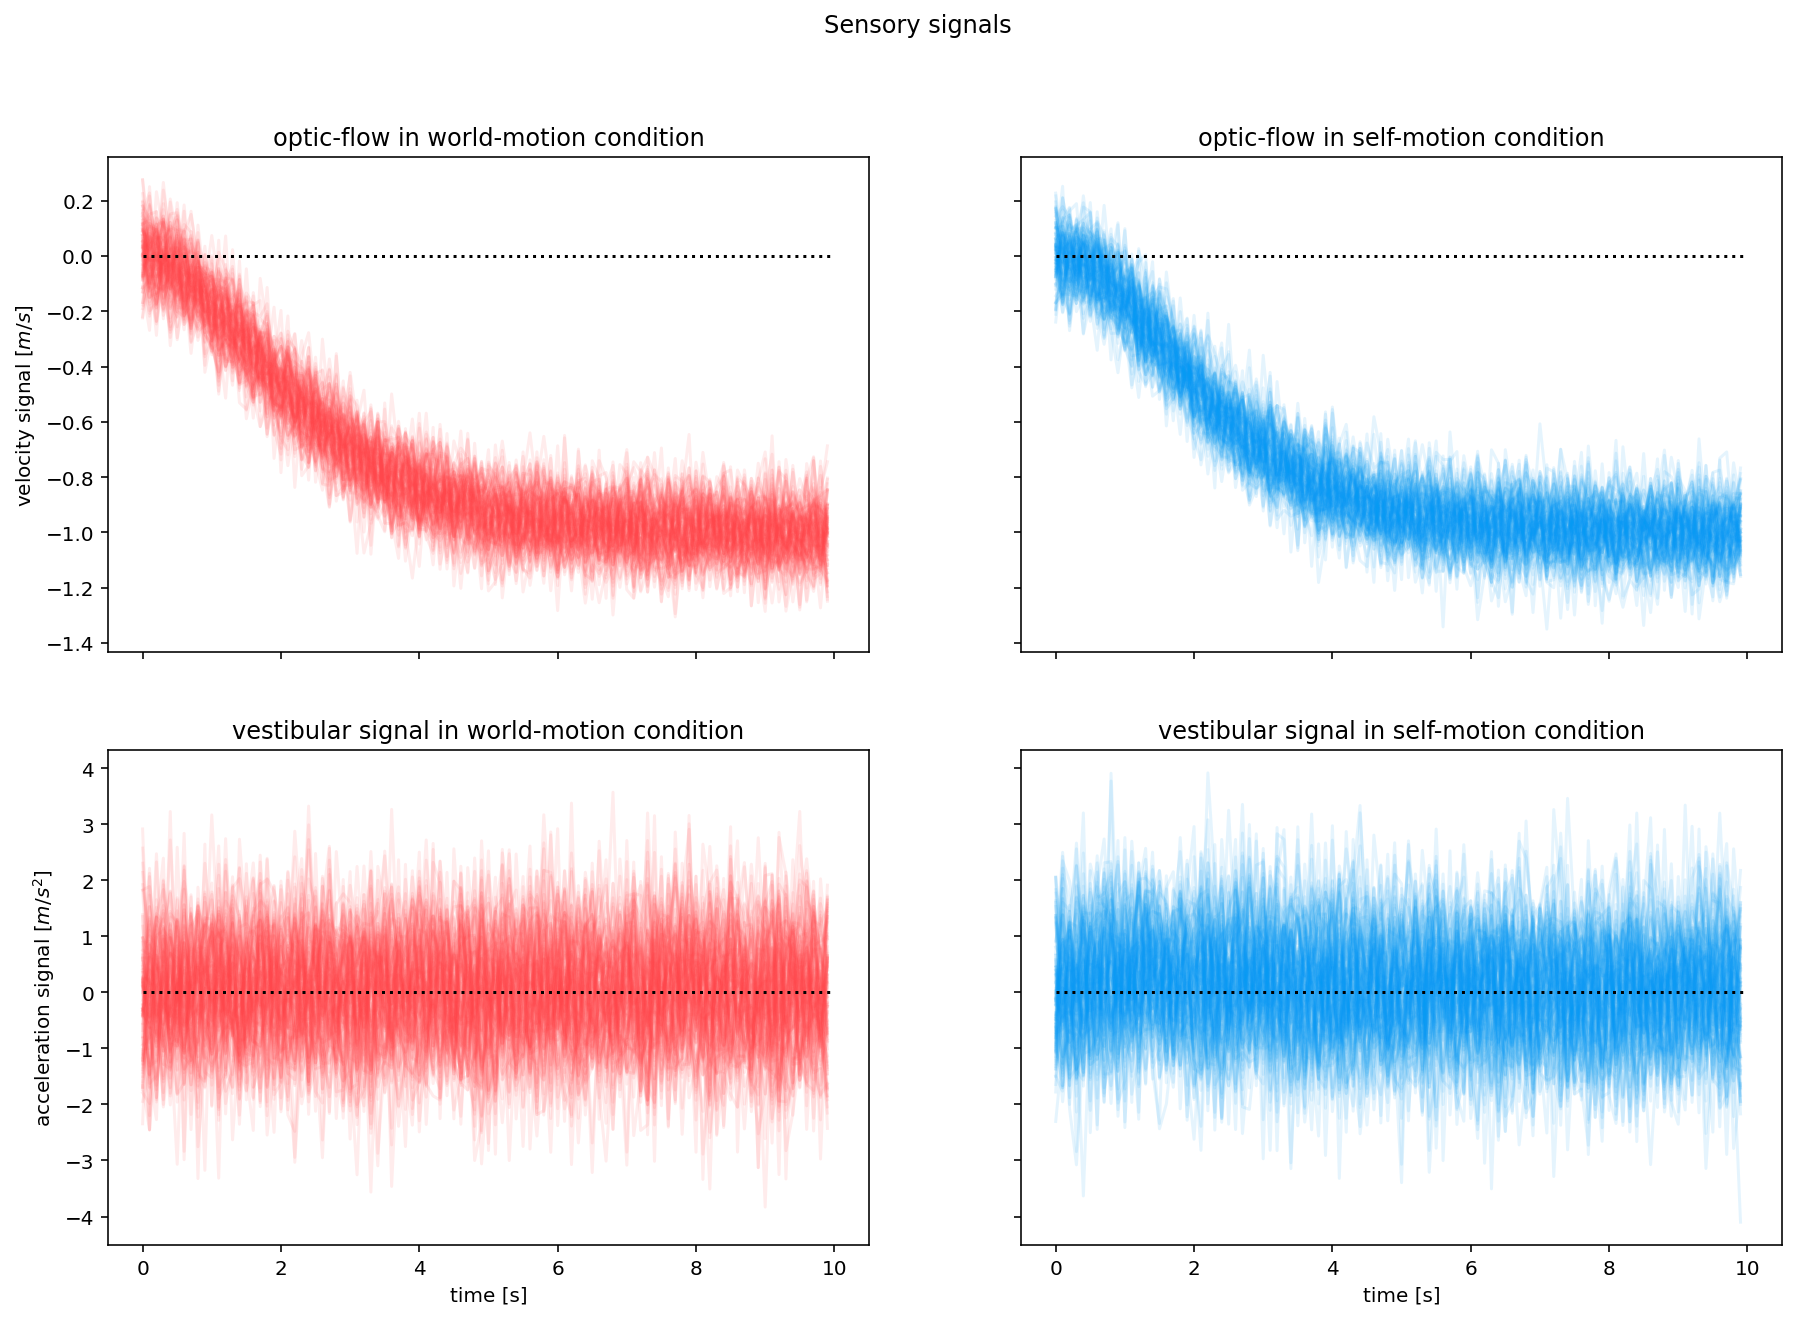

In [11]:
#@markdown **Run to plot raw noisy sensory signals**
# signals as they are:
my_plot_sensorysignals(judgments, opticflow, vestibular,
                       integrateVestibular=False)

## TD 2.2: Understanding the problem of noisy sensory information

**Answer the following questions:**
 * Is this what you expected?
 * In which of the two signals should we be able to see a difference between the conditions?
 * Can we use the data as it is to differentiate between the conditions? 
 * Can we compare the the visual and vestibular motion signals when they're in different units?
 * What would the brain do differentiate the two conditions?


Now that we know how to integrate the vestibular signal to get it into the same unit as the optic flow, we can see if it shows the pattern it should: a flat line in the world-motion condition and the correct velocity profile in the self-motion condition. Run the chunk of Python below to plot the sensory data again, but now with the vestibular signal integrated.


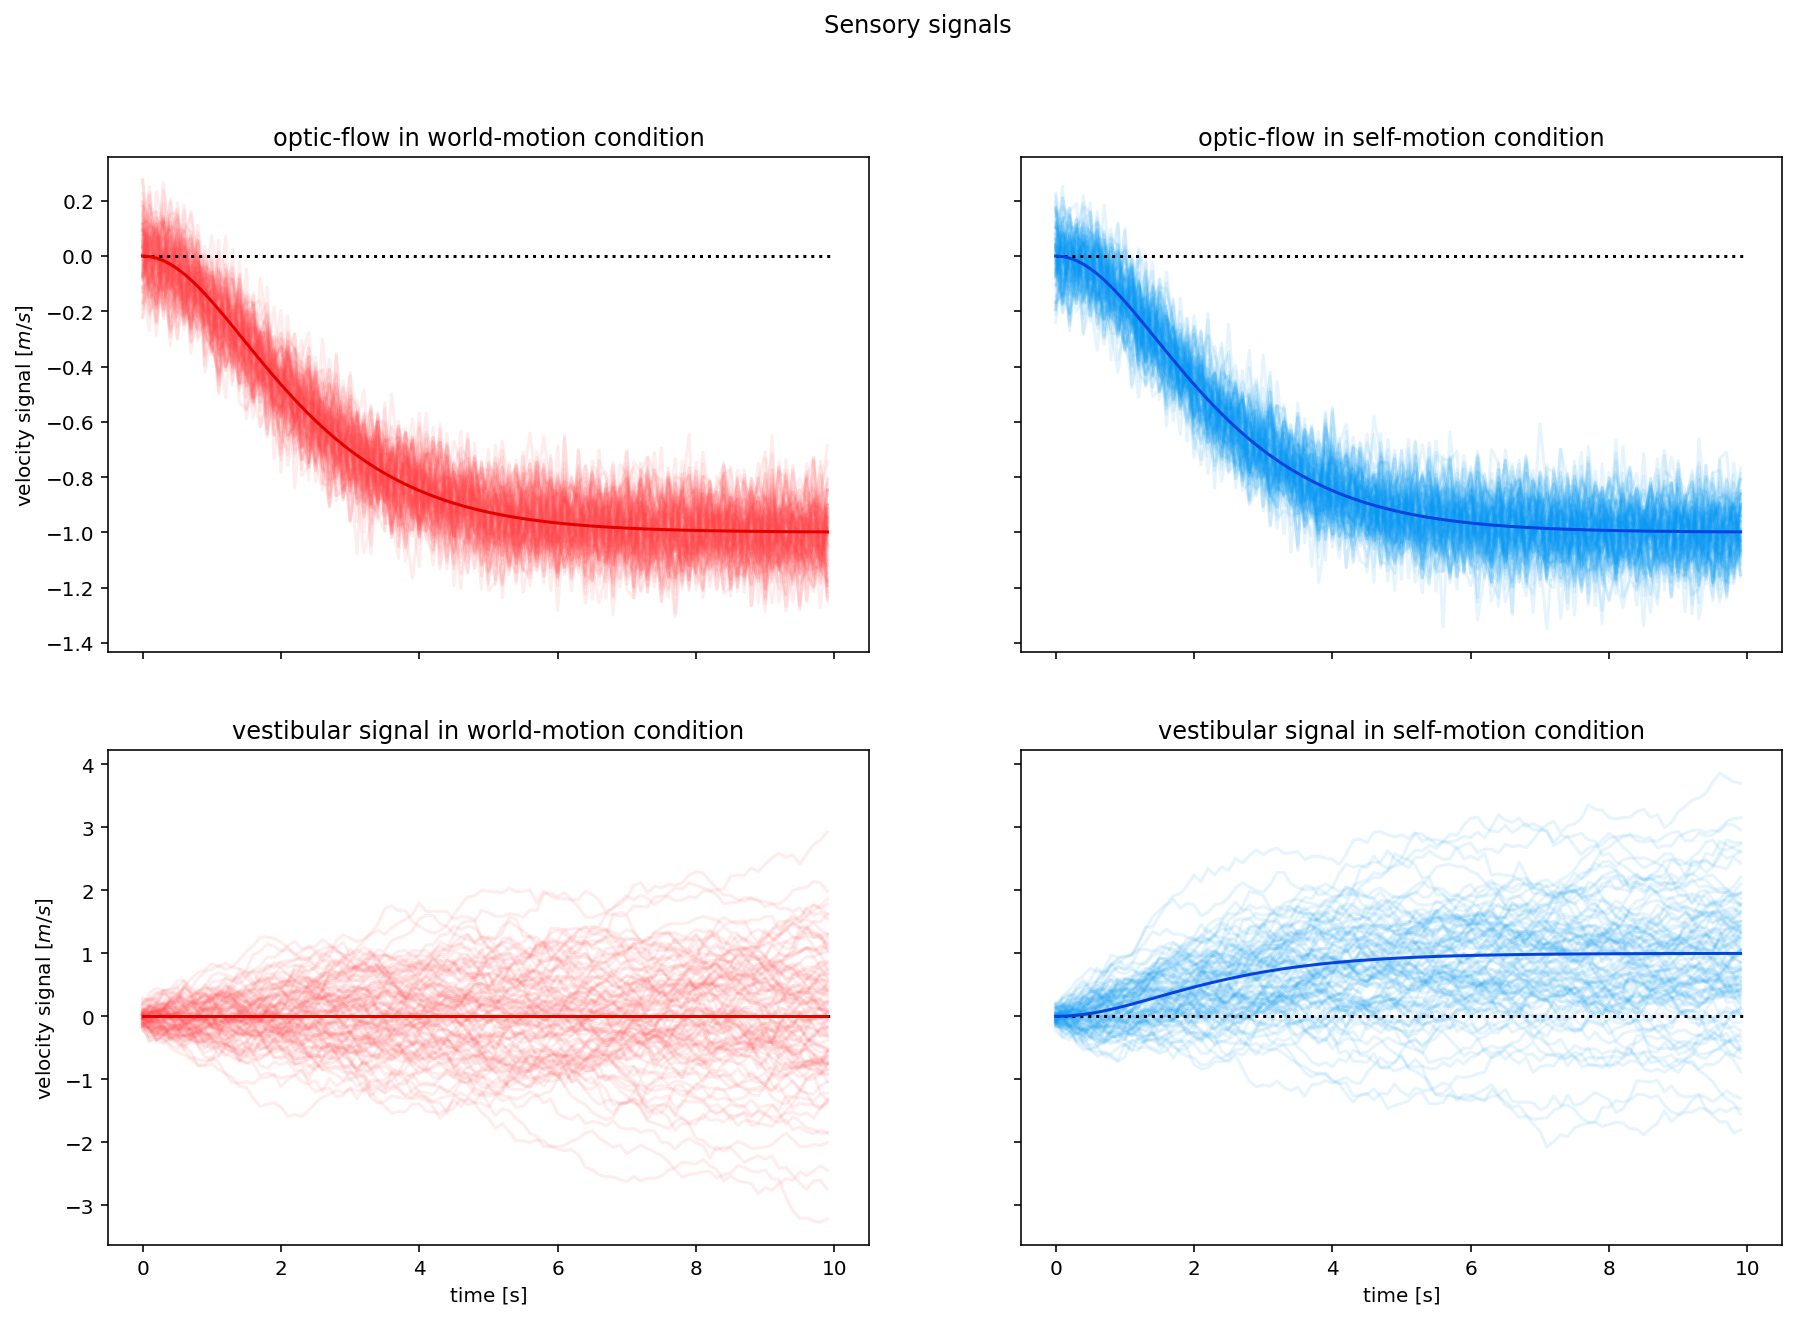

In [12]:
#@markdown **Run to compare true signals to sensory data**
my_plot_sensorysignals(judgments, opticflow, vestibular,
                       integrateVestibular=True, returnaxes=False,
                       addaverages=False, addGroundTruth=True)

The thick lines are the ground truth: the actual velocities in each of the conditions. With some effort, we can make out that _on average_ the vestibular signal does show the expected pattern after all. But there is also a lot of noise in the data.

**Background  Summary**:  

Now that we have examined the sensory signals, and understand how they relate to the ground truth. We see that there is enough information to _in principle_ disambiguate true self-motion from true world motion (there should be no illusion!). However, because the sensory information contains a lot of noise, i.e. it is unreliable, it could result in ambiguity.

**_It is time to refine our research question:_**

* Does the self-motion illusion occur due to unreliable sensory information?

---
# Section 3: Identifying ingredients

Video available at https://youtube.com/watch?v=ZQRtysK4OCo


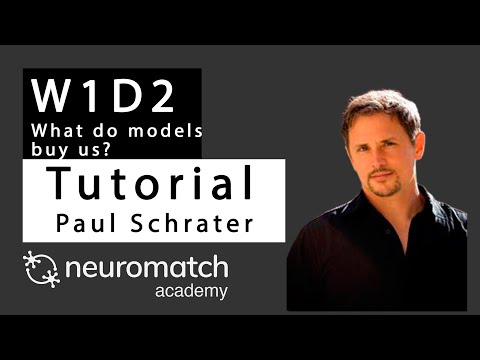

In [13]:
# @title Video 3: Ingredients
video = YouTubeVideo(id='ZQRtysK4OCo', width=854, height=480, fs=1)
print(f"Video available at https://youtube.com/watch?v={video.id}")
video

## TD 3.1: Understand the moving average function
**Goal**: think about what ingredients we will need for our model

We have access to sensory signals from the visual and vestibular systems that are used to estimate world motion and self motion.

However, there are still two issues:

1. _While sensory input can be noisy or unstable, perception is much more stable._
2. _In the judgments there is either self motion or not._

We will solve this by by using:

1. _a moving average filter_ to stabilize our sensory signals
2. _a threshold function_ to distinguish moving from non-moving


One of the simplest models of noise reduction is a moving average (sometimes: moving mean or rolling mean) over the recent past. In a discrete signal we specify the number of samples to use for the average (including the current one), and this is often called the _window size_. For more information on the moving average, check [this Wikipedia page](https://en.wikipedia.org/wiki/Moving_average).

In this tutorial there is a simple running average function available:

`my_moving_window(s, w)`: takes a signal time series $s$ and a window size $w$ as input and returns the moving average for all samples in the signal.




### Interactive Demo: Averaging window

The code below picks one vestibular signal, integrates it to get a velocity estimate for self motion, and then filters. You can set the window size.
Try different window sizes, then answer the following:

* What is the maximum window size? The minimum?
* Why does increasing the window size shift the curves? 
* How do the filtered estimates differ from the true signal?  


In [14]:
#@title
#@markdown Make sure you execute this cell to enable the widget!
t = np.arange(0, 10, .1)


def refresh(trial_number=101, window=15):
  # get the trial signal:
  signal = vestibular[trial_number - 1, :]
  # integrate it:
  signal = np.cumsum(signal * .1)
  # plot this signal
  plt.plot(t, signal, label='integrated vestibular signal')
  # filter:
  signal = my_moving_window(signal, window=window, FUN=np.mean)
  # plot filtered signal
  plt.plot(t, signal, label=f'filtered with window: {window}')
  plt.legend()
  plt.show()


_ = widgets.interact(refresh, trial_number=(1, 200, 1), window=(5, 100, 1))

interactive(children=(IntSlider(value=101, description='trial_number', max=200, min=1), IntSlider(value=15, de…

_Note: the function `my_moving_window()` is defined in this notebook in the code block at at the top called "Helper functions". It should be the first function there, so feel free to check how it works._

## TD 3.2: Thresholding the self-motion vestibular signal

Comparing the integrated, filtered (accumulated) vestibular signals with a threshold should allow determining if there is self motion or not.

To try this, we:
1. Integrate the vestibular signal, apply a moving average filter, and take the last value of each trial's vestibular signal as an estimate of self-motion velocity. 
2. Transfer the estimates of self-motion velocity into binary (0,1) decisions by comparing them to a threshold. Remember the output of logical comparators (>=<) are logical (truth/1, false/0). 1 indicates we think there was self-motion and 0 indicates otherwise. YOUR CODE HERE.
3. We sort these decisions separately for conditions of real world-motion vs. real self-motion to determine 'classification' accuracy.
4. To understand how the threshold impacts classfication accuracy, we do 1-3  for a range of thresholds.

There is one line fo code to complete, which will implement step 2.


#### Exercise 1: Threshold self-motion velocity into binary classifiction of self-motion

In [23]:
def my_threshold(selfmotion_vel_est, threshold):
  """
  This function should calculate proportion self motion
  for both conditions and the overall proportion
  correct classifications.

  Args:
      selfmotion_vel_est (numpy.ndarray): A sequence of floats
      indicating the estimated self motion for all trials.

      threshold (float): A threshold for the estimate of self motion when
      the brain decides there really is self motion.

  Returns:
      (numpy.ndarray): self-motion: yes or no.
  """

  ##############################################################
  # Compare the self motion estimates to the threshold:
  # Replace '...' with the proper code:
  # Remove the next line to test your function
  raise NotImplementedError("Modify my_threshold function")
  ##############################################################

  # Compare the self motion estimates to the threshold
  is_move = ...

  return is_move

In [24]:
# to_remove solution

def my_threshold(selfmotion_vel_est, threshold):
  """
  This function should calculate proportion self motion
  for both conditions and the overall proportion
  correct classifications.

  Args:
      selfmotion_vel_est (numpy.ndarray): A sequence of floats
      indicating the estimated self motion for all trials.

      threshold (float): A threshold for the estimate of self motion when
      the brain decides there really is self motion.

  Returns:
      self-motion: yes or no.
  """

  # Compare the self motion estimates to the threshold
  is_move = (selfmotion_vel_est > threshold)

  return is_move

### Interactive Demo: Threshold vs. averaging window

Now we combine the classification steps 1-3 above, for a variable threshold. This will allow us to find the threshold that produces the most accurate classification of self-motion.
We also add a 'widget' that controls the size of the moving average window. How does the optimal threshold vary with window size?

In [25]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

thresholds = np.round_(np.arange(0, 1.01, .01), 2)
v_ves = np.cumsum(vestibular * .1, axis=1)


def refresh(window=50):

  selfmotion_vel_est = my_moving_window(v_ves, window=window,
                                        FUN=np.mean)[:, 99]

  [pselfmove_nomove,
    pselfmove_move,
    pcorrect] = my_moving_threshold(selfmotion_vel_est, thresholds)

  my_plot_thresholds(thresholds, pselfmove_nomove, pselfmove_move, pcorrect)


_ = widgets.interact(refresh, window=(1, 100, 1))

interactive(children=(IntSlider(value=50, description='window', min=1), Output()), _dom_classes=('widget-inter…

Let's unpack this: 

Ideally, in the self-motion condition (orange line) we should always detect self motion, and never in the world-motion condition (blue line). This doesn't happen, regardless of the settings we pick. However, we can pick a threshold that gives the highest proportion correctly classified trials, which depends on the window size, but is between 0.2 and 0.4. We'll pick the optimal threshold for a window size of 100 (the full signal) which is at 0.33.

The ingredients we have collected for our model so far:
* integration: get the vestibular signal in the same unit as the visual signal
* running average: accumulate evidence over some time, so that perception is stable
* decision if there was self motion (threshold)

Since the velocity judgments are made at the end of the 10 second trials, it seems reasonable to use the sensory signals at the last sample to estimate what percept the participants said they had. 

---
# Section 4: Formulating hypotheses

In [ ]:
# @title Video 4: Hypotheses
video = YouTubeVideo(id='wgOpbfUELqU', width=854, height=480, fs=1)
print(f"Video available at https://youtube.com/watch?v={video.id}")
video


**Goal**: formulate reasonable hypotheses in mathematical language using the ingredients identified in step 3. Write hypotheses as a function that we evaluate the model against later.

**Question:** _Why do we experience the illusion?_

We know that there are two real motion signals, and that these drive two sensory signals:

> $w_v$: world motion (velocity magnitude)
> 
> $s_v$: self motion (velocity magnitude)
> 
> $s_{visual}$: optic flow signal
> 
> $s_{vestibular}$: vestibular signal

Optic flow is ambiguous, as both world motion and self motion drive visual motion.

$$s_{visual} = w_v - s_v + noise$$

Notice that world motion and self motion might cancel out. For example, if the train you are on, and the train you are looking at, both move at exactly the same speed.

Vestibular signals are driven only by self motion, but _can_ be ambiguous when they are noisy. 

$$s_{vestibular} = s_v + noise$$

**Combining Relationships**

Without the sensory noise, these two relations are two linear equations, with two unknowns!

This suggests the brain could simply "solve" for $s_v$ and $w_v$.  

However, given the noisy signals, sometimes these solutions will not be correct.  Perhaps that is enough to explain the illusion?


## TD 4.1: Write out Hypothesis

Use the discussion and framing to write out your hypothesis in the form:
> Illusory self-motion occurs when (give preconditions).  We hypothesize it occurs because (explain how our hypothesized relationships work)

## TD 4.2: Relate hypothesis to ingredients

Now it's time to pull together the ingredients and relate them to our hypothesis.  

**For each trial we have:**

| variable | description |
| ---- | ---- |
| $\hat{v_s}$ | **self motion judgment** (in m/s)|
| $\hat{v_w}$ | **world motion judgment** (in m/s)|
|  $s_{ves}$ | **vestibular info** filtered and integrated vestibular information  |
|  $s_{opt}$ | **optic flow info** filtered optic flow estibular information  |
| $z_s$ | **Self-motion detection** boolean value (True/False) indicating whether the vestibular info was above threshold or not |

Answer the following questions by replotting your data and ingredients: 

* which of the 5 variables do our hypothesis say should be related?
* what do you expect these plots to look like?  

 

In [ ]:
# Run to calculate variables
# these 5 lines calculate the main variables that we might use in the model
s_ves = my_moving_window(np.cumsum(vestibular * .1, axis=1), window=100)[:, 99]
s_opt = my_moving_window(opticflow, window=50)[:, 99]
v_s = s_ves
v_w = -s_opt - v_s
z_s = (s_ves > 0.33)

In the first chunk of code we plot histograms to compare the variability of the estimates of velocity we get from each of two sensory signals.

**Plot histograms**

In [ ]:
# Plot histograms
plt.figure(figsize=(8, 6))
plt.hist(s_ves, label='vestibular', alpha=0.5)  # set the first argument here
plt.hist(s_opt, label='visual', alpha=0.5)  # set the first argument here
plt.ylabel('frequency')
plt.xlabel('velocity estimate')
plt.legend(facecolor='xkcd:white')
plt.show()

This matches that the vestibular signals are noisier than visual signals.

Below is generic code to create scatter diagrams. Use it to see if the relationships between variables are the way you expect them. For example, what is the relationship between the estimates of self motion and world motion, as we calculate them here?

### Exercise 2: Build a scatter plot

In [ ]:
# this sets up a figure with some dotted lines on y=0 and x=0 for reference
plt.figure(figsize=(8, 8))
plt.plot([0, 0], [-0.5, 1.5], ':', color='xkcd:black')
plt.plot([-0.5, 1.5], [0, 0], ':', color='xkcd:black')

#############################################################################
# uncomment below and fill in with your code
#############################################################################

# determine which variables you want to look at (variable on the abscissa / x-axis, variable on the ordinate / y-axis)
# plt.scatter(...)

plt.xlabel('world-motion velocity [m/s]')
plt.ylabel('self-motion velocity [m/s]')
plt.show()

In [ ]:
# to_remove solution

# this sets up a figure with some dotted lines on y=0 and x=0 for reference
with plt.xkcd():

  plt.figure(figsize=(8, 8))
  plt.plot([0, 0], [-0.5, 1.5], ':', color='xkcd:black')
  plt.plot([-0.5, 1.5], [0, 0], ':', color='xkcd:black')

  # determine which variables you want to look at (variable on the abscissa / x-axis, variable on the ordinate / y-axis)
  plt.scatter(v_w, v_s)

  plt.xlabel('world-motion velocity [m/s]')
  plt.ylabel('self-motion velocity [m/s]')
  plt.show()

Below is code that uses $z_s$ to split the trials in into two categories (i.e., $s_{ves}$ below or above threshold) and plot the mean in each category.

### Exercise 3: Split variable means bar graph

In [ ]:
###################################
# Fill in source_var and uncomment
####################################

# source variable you want to check
source_var = ...

# below = np.mean(source_var[np.where(np.invert(z_s))[0]])
# above = np.mean(source_var[np.where(z_s)[0]] )

# plt.bar(x=[0, 1], height=[below, above])

plt.xticks([0, 1], ['below', 'above'])
plt.show()

In [ ]:
# to_remove solution

# source variable you want to check
source_var = v_w

below = np.mean(source_var[np.where(np.invert(z_s))[0]])
above = np.mean(source_var[np.where(z_s)[0]] )

with plt.xkcd():
  plt.bar(x=[0, 1], height=[below, above])

  plt.xticks([0, 1], ['below', 'above'])
  plt.show()


---
# Section 5: Toolkit selection

In [ ]:
# @title Video 5: Toolkit
video = YouTubeVideo(id='rsmnayVfJyM', width=854, height=480, fs=1)
print(f"Video available at https://youtube.com/watch?v={video.id}")
video

**Goal**: with the question, ingredients and hypotheses in mind, which toolkit (modeling approach) would be best to use?

**Toolkits**

The lecture covers the notion of toolkit.  Here we explain the toolkit we use in our simulation.

**Simulation as a generic tool** 

Because our data provides per trial data of both inputs and outputs, designing a _simulation_ is a powerful method.  

In general, simulation models have a typical structure:

![Generic Simulation](https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/NMA-W1D2-fig04.png)


Simulation models have:

* **inputs** including input variables, _and_ the ingredients needed to build the simulation functions.
* **simulation** which runs the model _many times_ on the inputs, over a range of scenarios (typically different parameter or model choices).  

 In addition, many simulations run _replications_, which are useful if components of your input or model are _stochastic_.
* **outputs** the output variables.  these may have replicas if the simulations are repeated to account for stochastic elements, which are perfect for statistical analysis.


_____
The elements of a simulation model are quite generic and occur in most models.  The most important considerations in deciding a toolkit are: 
* What types of mechanisms (causes, processes, systems) will you need to consider in your model?
* What aspects of the data and ingredients are _essential_ which are clearly _irrelevant_, and which can be abstracted over.

These considerations are completely determined by your research question.  To better understand this, we will engage you in a TA-led discussion.

## TD 5.1: TA-guided discussion about how questions drive toolkit selection.  


NOTES:   [See slides:](https://mfr.ca-1.osf.io/render?url=https://osf.io/v5emn/?direct%26mode=render%26action=download%26mode=render)

1. **DISCUSS MECHANISMS/INGREDIENTS NEEDED FOR QUESTIONS**: what kinds of mechanisms and ingredients are needed for the discussion questions

2. **DISCUSS WHAT INGREDIENTS DONT MATTER**: simulation / level of abstraction (depends on what is measured & is irrelevant to the question)





---
# Summary

In this tutorial, we worked through some steps of the process of modeling. 

- We defined a phenomenon and formulated a question (step 1)
- We collected information the state-of-the-art about the topic (step 2)
- We determined the basic ingredients (step 3), and used these to formulate a specific mathematically defined hypothesis (step 4), and
- We chose the most appropriate modeling approach (i.e., toolkit) for our phenomenon/background information/hypothesis (step 5)

In the next tutorial, we will continue with the steps 6-10!

---
# Reading

Blohm G, Kording KP, Schrater PR (2020). _A How-to-Model Guide for Neuroscience_ eNeuro, 7(1) ENEURO.0352-19.2019. https://doi.org/10.1523/ENEURO.0352-19.2019 

Dokka K, Park H, Jansen M, DeAngelis GC, Angelaki DE (2019). _Causal inference accounts for heading perception in the presence of object motion._ PNAS, 116(18):9060-9065. https://doi.org/10.1073/pnas.1820373116

Drugowitsch J, DeAngelis GC, Klier EM, Angelaki DE, Pouget A (2014). _Optimal Multisensory Decision-Making in a Reaction-Time Task._ eLife, 3:e03005. https://doi.org/10.7554/eLife.03005

Hartmann, M, Haller K, Moser I, Hossner E-J, Mast FW  (2014). _Direction detection thresholds of passive self-motion in artistic gymnasts._ Exp Brain Res, 232:1249–1258. https://doi.org/10.1007/s00221-014-3841-0

Mensh B, Kording K (2017). _Ten simple rules for structuring papers._ PLoS Comput Biol 13(9): e1005619. https://doi.org/10.1371/journal.pcbi.1005619

Seno T, Fukuda H (2012). _Stimulus Meanings Alter Illusory Self-Motion (Vection) - Experimental Examination of the Train Illusion._ Seeing Perceiving, 25(6):631-45. https://doi.org/10.1163/18784763-00002394
